In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score, brier_score_loss
)

import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

/Users/shyam/Desktop/Final Project

In [14]:
# Change filename if yours is different
RAW_FILE = "/Users/shyam/Desktop/Final Project/epl2022_player_stats.csv"

df = pd.read_csv(RAW_FILE)

# Keep real rows
df = df.dropna(subset=["player", "minutes", "rating"])
df = df[df["minutes"] > 0].copy()

# Safe fills for stats that can be genuinely zero
for c in ["goals","assists","shots","xG","passes","key_passes","yellow_cards","red_cards"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# Fantasy points (you can tweak weights)
df["fantasy_points"] = (
    df["goals"]*5 + df["assists"]*3 + df["key_passes"]*1 +
    df["shots"]*0.5 + df["passes"]*0.02 + df["xG"]*2 -
    df["yellow_cards"]*1 - df["red_cards"]*3
)

# Make sure we have identifiers
if "match_id" not in df.columns:
    # fallback if missing — still deterministic order
    df["match_id"] = pd.factorize(df["team"].astype(str) + "_" + df["player"].astype(str) + "_" + df.index.astype(str))[0]

df.to_csv("epl2022_cleaned.csv", index=False)
print("✅ cleaned:", df.shape)
df.head(3)


✅ cleaned: (2586, 15)


,match_id,team,player,position,minutes,rating,goals,assists,shots,xG,passes,key_passes,yellow_cards,red_cards,fantasy_points
0,867946,Crystal Palace,Vicente Guaita,G,90.0,6.2,0.0,0.0,0.0,0.0,37.0,0.0,0,0,0.74
1,867946,Crystal Palace,Nathaniel Clyne,D,90.0,6.3,0.0,0.0,0.0,0.0,56.0,1.0,1,0,1.12
2,867946,Crystal Palace,Joachim Andersen,D,90.0,7.9,0.0,0.0,0.0,0.0,104.0,1.0,0,0,3.08


In [15]:
df = pd.read_csv("/Users/shyam/Desktop/Final Project/epl2022_cleaned.csv").copy()

# Order key for "past-only" rolling features (replace with a real date if you have it)
df["order_key"] = df["match_id"]

# Opponent per match (take the other team in the same match_id)
teams_per_match = df.groupby('match_id')['team'].unique().to_dict()
def get_opponent(row):
    tlist = teams_per_match.get(row['match_id'], [])
    for t in tlist:
        if t != row['team']:
            return t
    return np.nan
df['opponent'] = df.apply(get_opponent, axis=1)

# Team match rating = median player rating for that team in that match
tmr = (df.groupby(['match_id','team'], as_index=False)['rating']
         .median().rename(columns={'rating':'team_match_rating'}))
df = df.merge(tmr, on=['match_id','team'], how='left')

# Team strength so far (expanding mean, shifted → past only)
df = df.sort_values(['team','order_key'])
df['team_strength_pre'] = (
    df.groupby('team')['team_match_rating']
      .apply(lambda s: s.expanding().mean().shift(1))
      .reset_index(level=0, drop=True)
)
# seed first with first match rating
df['team_strength_pre'] = df['team_strength_pre'].fillna(df.groupby('team')['team_match_rating'].transform('first'))

# Opponent strength so far
opp_tbl = (df[['match_id','team','team_strength_pre']]
           .drop_duplicates()
           .rename(columns={'team':'opponent','team_strength_pre':'opponent_strength_pre'}))
df = df.merge(opp_tbl, on=['match_id','opponent'], how='left')

# Rolling player form (past-only, window=3)
df = df.sort_values(['player','order_key'])
for col, newname in [('rating','form3_rating'),('xG','form3_xG'),('goals','form3_goals'),('shots','form3_shots')]:
    df[newname] = (
        df.groupby('player')[col]
          .apply(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
          .reset_index(level=0, drop=True)
    )

# Fills
df['opponent_strength_pre'] = df['opponent_strength_pre'].fillna(df['opponent_strength_pre'].median())
for c in ['form3_rating','form3_xG','form3_goals','form3_shots','team_strength_pre']:
    df[c] = df[c].fillna(0)

df.to_csv("epl2022_enhanced.csv", index=False)
print("✅ enhanced:", df.shape)
df.head(3)


✅ enhanced: (32698, 24)


,match_id,team,player,position,minutes,rating,goals,assists,shots,xG,...,fantasy_points,order_key,opponent,team_match_rating,team_strength_pre,opponent_strength_pre,form3_rating,form3_xG,form3_goals,form3_shots
29528,867977,West Ham,Aaron Cresswell,D,90.0,7.3,0.0,0.0,0.0,0.0,...,1.10,867977,Aston Villa,6.9,6.9,6.900000,0.00,0.0,0.0,0.0
29595,868045,West Ham,Aaron Cresswell,D,90.0,7.2,0.0,0.0,0.0,0.0,...,4.08,868045,Fulham,6.9,6.9,6.757143,7.30,0.0,0.0,0.0
29596,868045,West Ham,Aaron Cresswell,D,90.0,7.2,0.0,0.0,0.0,0.0,...,4.08,868045,Fulham,6.9,6.9,6.744828,7.25,0.0,0.0,0.0


In [16]:
df = pd.read_csv("epl2022_enhanced.csv")

# Target for CLASSIFICATION (good match)
df['target'] = (df['rating'] >= 7.0).astype(int)

# Encode position for models (keep raw for reporting)
df['position_raw'] = df['position'].astype(str)
pos_enc = LabelEncoder()
df['position_enc'] = pos_enc.fit_transform(df['position_raw'])

feature_cols = [
    "minutes","goals","assists","shots","xG","passes","key_passes",
    "yellow_cards","red_cards","position_enc",
    "team_strength_pre","opponent_strength_pre",
    "form3_rating","form3_xG","form3_goals","form3_shots"
]

# Chronological split (train earlier, test later)
df = df.sort_values('match_id').reset_index(drop=True)
split_idx = int(len(df)*0.8)
train_df, test_df = df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

X_train = train_df[feature_cols].copy()
X_test  = test_df[feature_cols].copy()
y_train = train_df['target'].astype(int)
y_test  = test_df['target'].astype(int)

# Scale ONLY for NN
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("train/test shapes:", X_train.shape, X_test.shape)


train/test shapes: (26158, 16) (6540, 16)


In [17]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=500, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, eval_metric='logloss', random_state=42
)
xgb_model.fit(X_train, y_train)
p_xgb = xgb_model.predict_proba(X_test)[:,1]

# Keras MLP
nn = Sequential([
    Input(shape=(X_train_s.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
history = nn.fit(
    X_train_s, y_train,
    validation_split=0.2,
    epochs=40, batch_size=64,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)
p_nn = nn.predict(X_test_s, verbose=0).ravel()

# Ensemble (soft vote)
ensemble_preds = (p_xgb + p_nn) / 2.0


Epoch 1/40
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.7994 - loss: 0.4478 - val_accuracy: 0.9289 - val_loss: 0.2153
Epoch 2/40
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.9068 - loss: 0.2532 - val_accuracy: 0.9262 - val_loss: 0.2044
Epoch 3/40
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.9247 - loss: 0.2270 - val_accuracy: 0.9325 - val_loss: 0.1916
Epoch 4/40
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.9310 - loss: 0.1997 - val_accuracy: 0.9316 - val_loss: 0.1809
Epoch 5/40
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.9403 - loss: 0.1861 - val_accuracy: 0.9392 - val_loss: 0.1883
Epoch 6/40
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.9428 - loss: 0.1744 - val_accuracy: 0.9396 - val_loss: 0.1728
Epoch 7/40
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.9472 - loss: 0.1600 - val_accuracy: 0.9482 - val_loss: 0.1577
Epoch 8/40
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.9545 - loss: 0.1483 - 

In [18]:
ths = np.linspace(0.05, 0.95, 19)
f1s = []
for t in ths:
    f1s.append(f1_score(y_test, (ensemble_preds >= t).astype(int), zero_division=0))
best_t = ths[int(np.argmax(f1s))]
ensemble_class = (ensemble_preds >= best_t).astype(int)

print(f"Chosen threshold by best F1: {best_t:.2f}")
print("ROC-AUC (XGB):", round(roc_auc_score(y_test, p_xgb), 3))
print("ROC-AUC (NN ):", round(roc_auc_score(y_test, p_nn), 3))
print("ROC-AUC (ENS):", round(roc_auc_score(y_test, ensemble_preds), 3))
print("\nClassification report (ENS @ best F1):\n",
      classification_report(y_test, ensemble_class, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_test, ensemble_class))
print("Brier score:", round(brier_score_loss(y_test, ensemble_preds), 4))


Chosen threshold by best F1: 0.50
ROC-AUC (XGB): 0.981
ROC-AUC (NN ): 0.98
ROC-AUC (ENS): 0.983

Classification report (ENS @ best F1):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4221
           1       0.94      0.94      0.94      2319

    accuracy                           0.96      6540
   macro avg       0.96      0.96      0.96      6540
weighted avg       0.96      0.96      0.96      6540

Confusion matrix:
 [[4092  129]
 [ 133 2186]]
Brier score: 0.0359


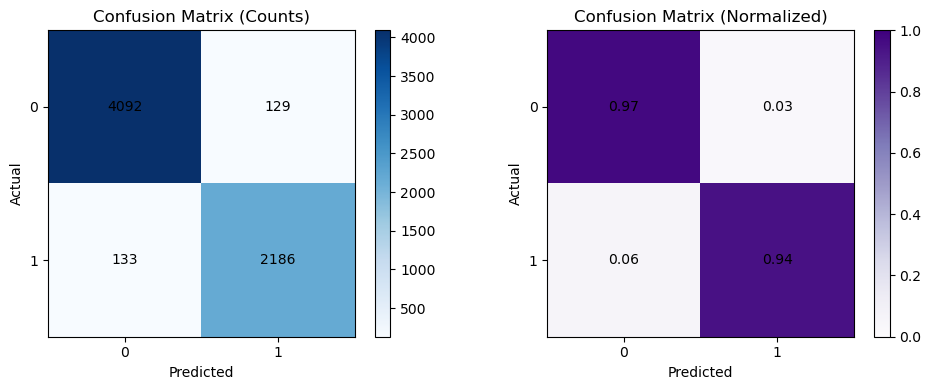

In [19]:
cm = confusion_matrix(y_test, ensemble_class)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

im0 = ax[0].imshow(cm, cmap='Blues')
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('Actual')
ax[0].set_xticks([0,1]); ax[0].set_yticks([0,1])
for (i,j),v in np.ndenumerate(cm):
    ax[0].text(j, i, str(v), ha='center', va='center')
fig.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(cm_norm, cmap='Purples', vmin=0, vmax=1)
ax[1].set_title('Confusion Matrix (Normalized)')
ax[1].set_xlabel('Predicted'); ax[1].set_ylabel('Actual')
ax[1].set_xticks([0,1]); ax[1].set_yticks([0,1])
for (i,j),v in np.ndenumerate(cm_norm):
    ax[1].text(j, i, f"{v:.2f}", ha='center', va='center')
fig.colorbar(im1, ax=ax[1], fraction=0.046)

plt.tight_layout(); plt.show()


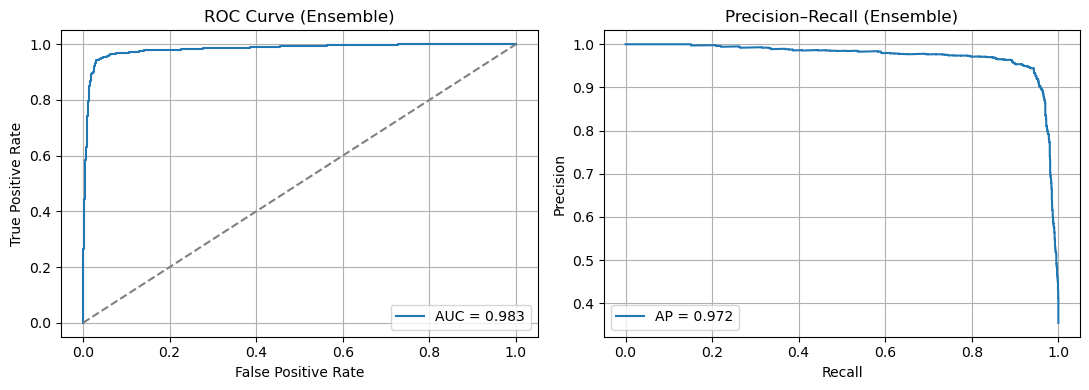

In [20]:
# ROC
fpr, tpr, _ = roc_curve(y_test, ensemble_preds)
roc_auc = auc(fpr, tpr)

# PR
prec, rec, _ = precision_recall_curve(y_test, ensemble_preds)
ap = average_precision_score(y_test, ensemble_preds)

plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Ensemble)'); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall (Ensemble)'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()


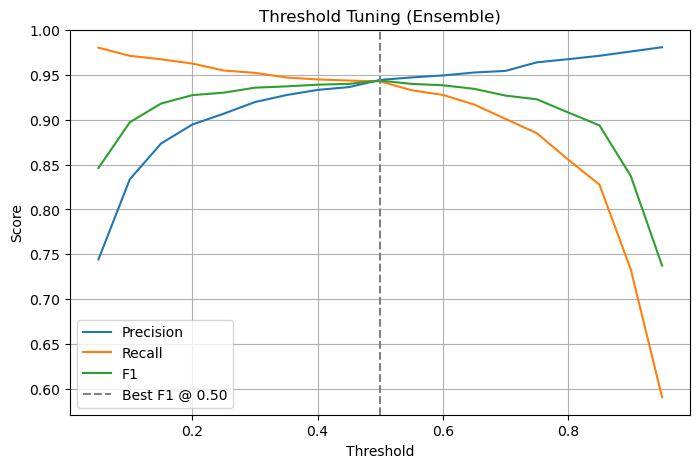

In [21]:
precisions, recalls, f1s = [], [], []
for t in ths:
    y_hat = (ensemble_preds >= t).astype(int)
    precisions.append(precision_score(y_test, y_hat, zero_division=0))
    recalls.append(recall_score(y_test, y_hat, zero_division=0))
    f1s.append(f1_score(y_test, y_hat, zero_division=0))

plt.figure(figsize=(8,5))
plt.plot(ths, precisions, label='Precision')
plt.plot(ths, recalls, label='Recall')
plt.plot(ths, f1s, label='F1')
plt.axvline(best_t, ls='--', color='gray', label=f'Best F1 @ {best_t:.2f}')
plt.xlabel('Threshold'); plt.ylabel('Score'); plt.title('Threshold Tuning (Ensemble)')
plt.legend(); plt.grid(True); plt.show()


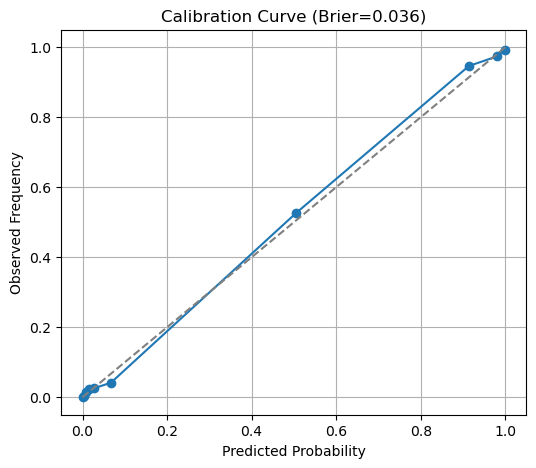

In [22]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, ensemble_preds, n_bins=10, strategy='quantile')
brier = brier_score_loss(y_test, ensemble_preds)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('Predicted Probability'); plt.ylabel('Observed Frequency')
plt.title(f'Calibration Curve (Brier={brier:.3f})')
plt.grid(True); plt.show()


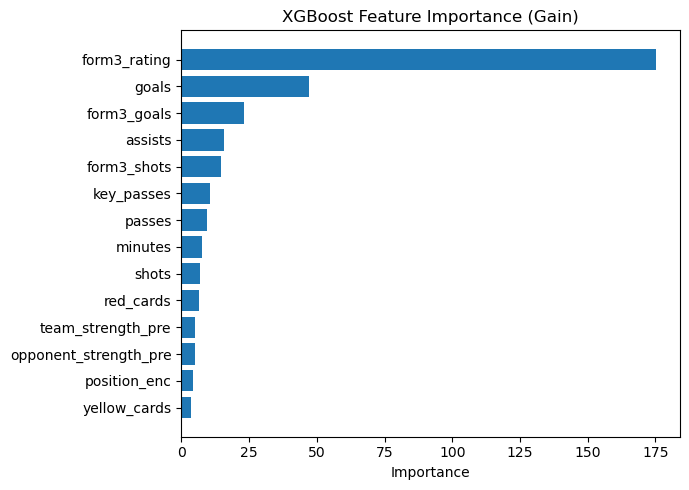

In [23]:
booster = xgb_model.get_booster()
gain = booster.get_score(importance_type='gain')

feat = np.array(list(gain.keys()))
vals = np.array(list(gain.values()), dtype=float)
order = np.argsort(vals)[::-1]

plt.figure(figsize=(7,5))
plt.barh(feat[order], vals[order])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importance (Gain)')
plt.xlabel('Importance')
plt.tight_layout(); plt.show()


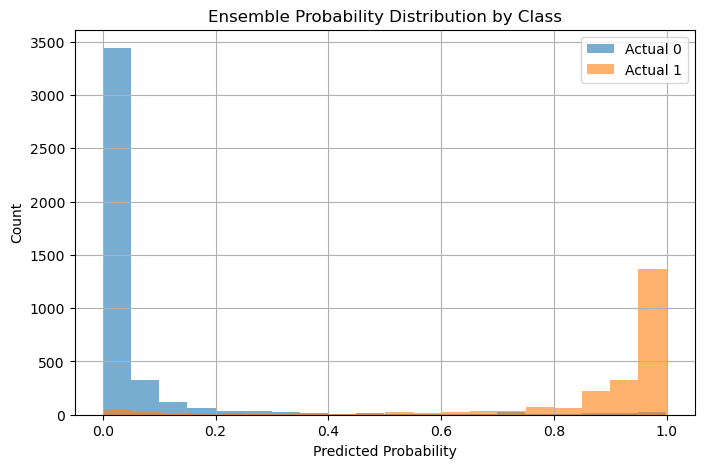

In [24]:
pos = ensemble_preds[np.array(y_test)==1]
neg = ensemble_preds[np.array(y_test)==0]

plt.figure(figsize=(8,5))
plt.hist(neg, bins=20, alpha=0.6, label='Actual 0')
plt.hist(pos, bins=20, alpha=0.6, label='Actual 1')
plt.xlabel('Predicted Probability'); plt.ylabel('Count')
plt.title('Ensemble Probability Distribution by Class')
plt.legend(); plt.grid(True); plt.show()


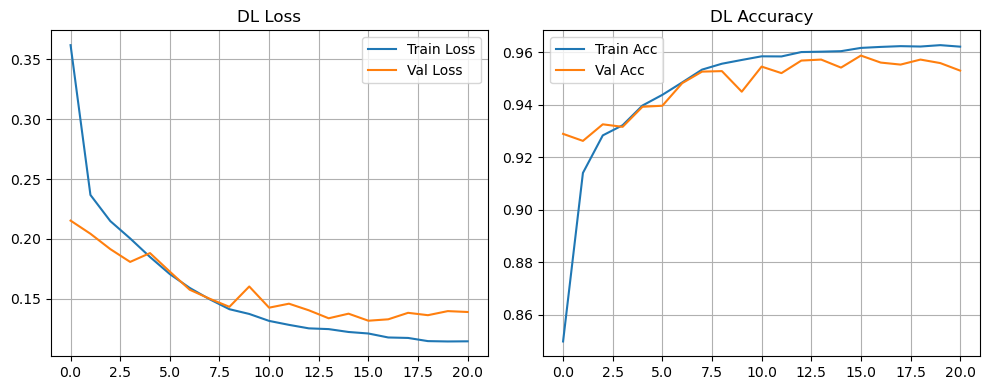

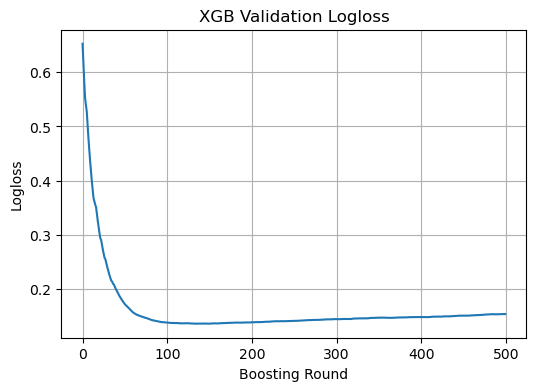

In [25]:
# DL learning curves
try:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('DL Loss'); plt.legend(); plt.grid(True)

    if 'accuracy' in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title('DL Accuracy'); plt.legend(); plt.grid(True)

    plt.tight_layout(); plt.show()
except Exception as e:
    print("No Keras history available:", e)

# Refit tiny XGB with eval_set to plot validation logloss
try:
    xgb_eval = xgb.XGBClassifier(**{k:v for k,v in xgb_model.get_params().items() if k != 'eval_metric'})
    xgb_eval.set_params(eval_metric='logloss')
    xgb_eval.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    results = xgb_eval.evals_result()
    if 'validation_0' in results and 'logloss' in results['validation_0']:
        plt.figure(figsize=(6,4))
        plt.plot(results['validation_0']['logloss'])
        plt.title('XGB Validation Logloss'); plt.xlabel('Boosting Round'); plt.ylabel('Logloss')
        plt.grid(True); plt.show()
except Exception as e:
    print("Skipped XGB eval plot:", e)


In [26]:
# ==== DECISION ENGINE: pick Best XI from model predictions ====
# Prereqs from earlier cells:
# - test_df : dataframe of holdout rows with columns ['player','team','position', ...]
# - ensemble_preds : numpy array of predicted prob (len = len(test_df))
# If your names differ, adapt below.

import pandas as pd
import numpy as np

# 0) Build a prediction table for the holdout set
dec = test_df.reset_index(drop=True).copy()
dec['pred_good_prob'] = np.asarray(ensemble_preds).ravel()

# Keep useful context for explanation (auto-fill if missing)
for col in ['minutes','rating','goals','assists','form3_rating','form3_xG','team_strength_pre','opponent_strength_pre','opponent']:
    if col not in dec.columns:
        dec[col] = np.nan

# Normalize position label variants
dec['position_raw'] = dec.get('position_raw', dec.get('position', '').astype(str))
dec['posG'] = dec['position_raw'].str.startswith('G')
dec['posD'] = dec['position_raw'].str.startswith('D')
dec['posM'] = dec['position_raw'].str.startswith('M')
dec['posF'] = dec['position_raw'].str.startswith('F')

# 1) Knobs — edit these for different strategies
FORMATION = {'G':1, 'D':4, 'M':4, 'F':2}   # 1-4-4-2 by default
MAX_PER_TEAM = 3                            # fantasy-style cap
MIN_MINUTES = 30                            # filter low-minute cameos from candidates
TOP_K_POOL = {'G':10, 'D':60, 'M':60, 'F':30}  # candidate pool size per line

# Optional budget: if you have a 'price' column, set a cap; else leave None
BUDGET_CAP = None  # e.g., 100.0
PRICE_COL = 'price' if 'price' in dec.columns else None

# Filter sensible candidates
cand = dec.query('minutes >= @MIN_MINUTES').copy()

# Build pool per line
def pool_for(prefix, k):
    return (cand[cand['position_raw'].str.startswith(prefix)]
            .sort_values('pred_good_prob', ascending=False)
            .head(k))
pool = pd.concat([
    pool_for('G', TOP_K_POOL['G']),
    pool_for('D', TOP_K_POOL['D']),
    pool_for('M', TOP_K_POOL['M']),
    pool_for('F', TOP_K_POOL['F']),
], ignore_index=True).reset_index(drop=True)

# 2) Try ILP (PuLP). If unavailable or infeasible, fall back to greedy.
selected = None
reason = ""

try:
    import pulp

    # Decision vars
    pool['var'] = [pulp.LpVariable(f"pick_{i}", lowBound=0, upBound=1, cat='Binary') for i in pool.index]

    # Problem
    prob = pulp.LpProblem("Best_XI", pulp.LpMaximize)

    # Objective: maximize predicted good-performance probability
    prob += pulp.lpSum(pool.loc[i, 'pred_good_prob'] * pool.loc[i, 'var'] for i in pool.index)

    # Formation constraints
    def cnt(prefix):
        return pulp.lpSum(pool.loc[i, 'var'] for i in pool.index if str(pool.loc[i,'position_raw']).startswith(prefix))

    for pfx, need in FORMATION.items():
        prob += cnt(pfx) == need

    # Total players = 11
    prob += pulp.lpSum(pool['var']) == sum(FORMATION.values())

    # Team cap
    for t in pool['team'].dropna().unique():
        prob += pulp.lpSum(pool.loc[i, 'var'] for i in pool.index if pool.loc[i,'team'] == t) <= MAX_PER_TEAM

    # Optional budget
    if BUDGET_CAP is not None and PRICE_COL is not None:
        prob += pulp.lpSum(pool.loc[i, PRICE_COL] * pool.loc[i, 'var'] for i in pool.index) <= float(BUDGET_CAP)

    # Solve
    _ = prob.solve(pulp.PULP_CBC_CMD(msg=False))

    if pulp.LpStatus[prob.status] == 'Optimal':
        selected = pool[pool['var'].apply(lambda v: v.value()) > 0.5].copy()
        reason = "ILP optimal XI"
    else:
        reason = f"ILP status={pulp.LpStatus[prob.status]}; falling back to greedy"

except Exception as e:
    reason = f"No ILP (PuLP) or error: {e}; falling back to greedy"

# 3) Greedy fallback (simple, per-line best not violating team caps or budget)
def greedy_pick(pool, formation, max_per_team, budget_cap=None, price_col=None):
    chosen = []
    team_counts = {}
    budget_used = 0.0

    for pfx, need in formation.items():
        candidates = (pool[pool['position_raw'].str.startswith(pfx)]
                      .sort_values('pred_good_prob', ascending=False).copy())
        for _, row in candidates.iterrows():
            if len([c for c in chosen if c['position_raw'].startswith(pfx)]) >= need:
                break
            # team cap
            t = row['team']
            if t is not None and team_counts.get(t, 0) >= max_per_team:
                continue
            # budget
            if budget_cap is not None and price_col is not None:
                price = float(row[price_col]) if not pd.isna(row[price_col]) else 0.0
                if budget_used + price > budget_cap:
                    continue

            chosen.append(row)
            team_counts[t] = team_counts.get(t, 0) + 1
            if budget_cap is not None and price_col is not None:
                budget_used += price
    if len(chosen) == sum(formation.values()):
        return pd.DataFrame(chosen)
    return pd.DataFrame()  # fail

if selected is None or selected.empty:
    selected = greedy_pick(pool, FORMATION, MAX_PER_TEAM, BUDGET_CAP, PRICE_COL)
    if selected.empty:
        raise RuntimeError("Could not assemble a valid XI with the given constraints/filters. Relax them and retry.")
    else:
        reason = "Greedy XI"

# 4) Produce outputs: XI, Bench (next best per line), team distribution, rationale columns
cols_show = ['player','team','position_raw','pred_good_prob','minutes','rating','goals','assists',
             'form3_rating','form3_xG','team_strength_pre','opponent_strength_pre','opponent']
if PRICE_COL:
    cols_show.insert(4, PRICE_COL)

XI = selected.sort_values('position_raw').loc[:, [c for c in cols_show if c in selected.columns]]

# Bench: top alternates not selected, respecting role
picked_ids = set(selected.index)
bench_rows = []
for pfx, need in FORMATION.items():
    alt = (pool[pool['position_raw'].str.startswith(pfx)]
           .drop(index=picked_ids, errors='ignore')
           .sort_values('pred_good_prob', ascending=False)
           .head(max(2, int(np.ceil(need/2)))))
    bench_rows.append(alt)
BENCH = pd.concat(bench_rows, ignore_index=True).loc[:, [c for c in cols_show if c in pool.columns]]

# Team distribution
team_dist = XI['team'].value_counts().sort_values(ascending=False)

# 5) Print results
print(f"✅ Best XI selected via: {reason}")
print("\n=== BEST XI (formation "
      + "-".join([str(FORMATION[k]) for k in ['G','D','M','F'] if k in FORMATION])
      + f", ≤{MAX_PER_TEAM}/team) ===")
display(XI)

print("\n=== BENCH OPTIONS (per line, next best) ===")
display(BENCH)

print("\n=== TEAM DISTRIBUTION (XI) ===")
print(team_dist)


✅ Best XI selected via: ILP optimal XI

=== BEST XI (formation 1-4-4-2, ≤3/team) ===


,player,team,position_raw,pred_good_prob,minutes,rating,goals,assists,form3_rating,form3_xG,team_strength_pre,opponent_strength_pre,opponent
10,Lyanco,Southampton,D,0.999923,52.0,7.7,1.0,0.0,7.700000,0.0,6.651504,6.620438,Nottingham Forest
11,Lyanco,Southampton,D,0.999920,52.0,7.7,1.0,0.0,7.700000,0.0,6.651504,6.618116,Nottingham Forest
12,Lyanco,Southampton,D,0.999919,52.0,7.7,1.0,0.0,7.700000,0.0,6.651504,6.615827,Nottingham Forest
36,Pascal Groß,Brighton,D,0.999740,90.0,7.0,0.0,0.0,7.000000,0.0,6.904643,6.834783,Everton
130,Morgan Gibbs-White,Nottingham Forest,F,0.999980,90.0,8.5,1.0,1.0,7.966667,0.0,6.604861,6.666129,Southampton
131,Riyad Mahrez,Manchester City,F,0.999979,90.0,8.0,0.0,2.0,8.000000,0.0,7.053846,6.671429,Leeds
0,Sam Johnstone,Crystal Palace,G,0.974086,90.0,7.6,0.0,0.0,7.600000,0.0,6.643820,6.670248,Southampton
76,Antony,Manchester United,M,0.999972,90.0,8.7,1.0,1.0,8.700000,0.0,7.014423,6.623622,Nottingham Forest
77,Antony,Manchester United,M,0.999972,90.0,8.7,1.0,1.0,8.700000,0.0,7.014423,6.622400,Nottingham Forest
78,Antony,Manchester United,M,0.999972,90.0,8.7,1.0,1.0,8.700000,0.0,7.014423,6.621774,Nottingham Forest



=== BENCH OPTIONS (per line, next best) ===


,player,team,position_raw,pred_good_prob,minutes,rating,goals,assists,form3_rating,form3_xG,team_strength_pre,opponent_strength_pre,opponent
0,Sam Johnstone,Crystal Palace,G,0.974068,90.0,7.6,0.0,0.0,7.6,0.0,6.643820,6.670833,Southampton
1,Sam Johnstone,Crystal Palace,G,0.974049,90.0,7.6,0.0,0.0,7.6,0.0,6.643820,6.671429,Southampton
2,Lyanco,Southampton,D,0.999919,52.0,7.7,1.0,0.0,7.7,0.0,6.651504,6.613571,Nottingham Forest
3,Lyanco,Southampton,D,0.999919,52.0,7.7,1.0,0.0,7.7,0.0,6.651504,6.611348,Nottingham Forest
4,James Ward-Prowse,Southampton,M,0.999972,90.0,8.7,1.0,1.0,8.7,0.0,6.661024,6.594631,Nottingham Forest
5,James Ward-Prowse,Southampton,M,0.999972,90.0,8.7,1.0,1.0,8.7,0.0,6.661024,6.598639,Nottingham Forest
6,Morgan Gibbs-White,Nottingham Forest,F,0.999977,90.0,8.5,1.0,1.0,8.5,0.0,6.604861,6.664400,Southampton
7,Morgan Gibbs-White,Nottingham Forest,F,0.999977,90.0,8.5,1.0,1.0,8.5,0.0,6.604861,6.647059,Southampton



=== TEAM DISTRIBUTION (XI) ===
team
Southampton          3
Manchester United    3
Manchester City      2
Brighton             1
Nottingham Forest    1
Crystal Palace       1
Name: count, dtype: int64
